In [ ]:
%matplotlib inline
!pip install keras>=2.9.0
!pip install keras_preprocessing
!pip install tensorflow_addons
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow_addons.layers import *
from tensorflow.keras.losses import MSE
from PIL import Image
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
import glob
import cv2
import matplotlib.pyplot as plt
from keras.losses import MeanSquaredError
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from scipy import misc
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Concatenate, Conv2DTranspose, LeakyReLU, Dropout


import os

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 35.8 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [ ]:



import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Activation, Concatenate, Conv2DTranspose, LeakyReLU, Dropout
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
input_dim = (128,128,3) #input/output image dimension
depth = 4               #network depth
kernel = 3              #kernel size for Conv2D
n_batch = 16            #batch_size
epochs = 10
steps = round(1500/n_batch) #steps per epoch, we have ~1500 samples per domain so calculating steps using it


In [ ]:
path_to_dataset = '/content/gdrive/MyDrive/UnderWater_Dataset/Project/'
train_path_A = '/content/gdrive/MyDrive/UnderWater_Dataset/Project/trainA'
train_path_B = '/content/gdrive/MyDrive/UnderWater_Dataset/Project/trainB'
test_path_A = '/content/gdrive/MyDrive/UnderWater_Dataset/Project/testA/'
test_path_B = '/content/gdrive/MyDrive/UnderWater_Dataset/Project/testB/'

In [ ]:
from tensorflow.python.data.ops.dataset_ops import Dataset
def preprocess(records):
    images =  records['image']
    images = tf.cast(images, tf.float32)/255.0
    return images


def tf_pipeline(dataset, datasetname):
    processed_data_paired = []
    processed_data_unpaired = []
    for i, image in enumerate(dataset):
        filename = datasetname[i]
        if filename[58] == 'a':
            processed_data_paired.append(image)
        else:
            processed_data_unpaired.append(image)
    if filename[56] == 'B':
      length = len(processed_data_paired)
      imageHold1 = processed_data_paired[length - 1]
      imageHold2 = processed_data_paired[length - 2]
      processed_data_paired[length - 2] = imageHold1
      processed_data_paired[length - 1] = imageHold2
    paired = tf.data.Dataset.from_tensor_slices({'image':processed_data_paired})
    paired = paired.map(preprocess)
    paired = paired.repeat().shuffle(100).batch(n_batch).prefetch(1)
    unpaired = tf.data.Dataset.from_tensor_slices({'image':processed_data_unpaired})
    unpaired = unpaired.map(preprocess)
    unpaired = unpaired.repeat().shuffle(100).batch(n_batch).prefetch(1)
    return paired, unpaired
    
def tf_data(path):
    trainingA = []
    trainingANames = []
    for x in glob.glob(path+'trainA/*'):
        image = Image.open(x)
        nameFile = image.filename
        trainingANames.append(nameFile)
        image = image.resize((128,128))
        image = np.array(image)
        trainingA.append(image)
        
    trainingB = []
    trainingBNames = []
    for x in glob.glob(path+'trainB/*'):
        image = Image.open(x)
        nameFile = image.filename
        trainingBNames.append(nameFile)
        image = image.resize((128,128))
        image = np.array(image)
        trainingB.append(image)
    pairedA, unpairedA = tf_pipeline(trainingA, trainingANames)
    pairedB, unpairedB = tf_pipeline(trainingB, trainingBNames)
    return pairedA.__iter__(), unpairedA.__iter__(), pairedB.__iter__(), unpairedB.__iter__()


trainPairedA, trainUnpairedA, trainPairedB, trainUnpairedB = tf_data(path_to_dataset)

In [ ]:
def discriminator(input_dim,depth,kernel):
    layers = []
    layers.append(Input(shape=input_dim))
    for i in range(1,depth):
            layers.append(Conv2D(16*i,kernel_size=kernel))
            layers.append(InstanceNormalization())
            layers.append(Activation('relu'))
            layers.append(Dropout(0.2))
    layers.append(Conv2D(1,kernel_size=kernel))
    model = Sequential(layers)
    model.compile(loss='mse',optimizer=tf.keras.optimizers.Adam())
    return model
discriminator_A = discriminator(input_dim,depth,kernel)
discriminator_B = discriminator(input_dim,depth,kernel)


In [ ]:
def generator(input_dim, depth, kernel):
    layers = []
    layers.append(Input(shape=input_dim))
    for i in range(1,depth):
        layers.append(Conv2D(16*i,kernel_size=kernel))
        layers.append(InstanceNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(0.2))
    
    for i in range(1,depth):
        layers.append(Conv2DTranspose(16*i,kernel_size=kernel))
        layers.append(InstanceNormalization())
        layers.append(Activation('relu'))
        layers.append(Dropout(0.2))
    
    resizer =  lambda name: Lambda(lambda images: tf.image.resize(images, [128,128]), name=name)
    layers.append(resizer('Reshape'))
    layers.append(Conv2DTranspose(3,kernel_size=1,activation=None))
    model = Sequential(layers)
    return model
generator_A_B = generator(input_dim,depth,kernel)
generator_B_A = generator(input_dim,depth,kernel)

In [ ]:
def composite_model(g1, d, g2, image_dim):
    g1.trainable = True
    g2.trainable = False
    d.trainable = False

    # Adversarial loss 
    input_img = Input(shape=input_dim)
    g1_out = g1(input_img)
    d_out = d(g1_out)

    # Identity loss
    input_id = Input(shape=input_dim)
    g1_out_id = g2(input_id)

    #Cycle Loss, Forward cycle
    g2_out = g2(g1_out)
    
    #Cycle Loss, Backward-cycle
    g2_out_id = g2(input_id)
    output_g1 = g1(g2_out_id)

    # Paired loss
    is_paired = Input(shape=input_dim)
    paired_img = Input(shape=input_dim)
    paired_processed = tf.subtract(paired_img, g1_out)
    paired_processed = tf.math.multiply(paired_processed, is_paired)


    # Combined model
    model = Model(inputs=[input_img, input_id, paired_img, is_paired], outputs=[d_out, g1_out_id, g2_out, output_g1, paired_processed])
    model.compile(loss=['mse', 'mae', 'mae', 'mae', 'mae'], loss_weights=[1,5,10,10,1], optimizer=tf.keras.optimizers.Adam())
    return model
composite_A_B = composite_model(generator_A_B, discriminator_B, generator_B_A, input_dim)
composite_B_A = composite_model(generator_B_A, discriminator_A, generator_A_B, input_dim)

In [ ]:
def generate_real(dataset, n_batch,patch_size):
    labels = np.ones((n_batch,patch_size,patch_size,1))
    return dataset,labels
def generate_fake(dataset,g,patch_size):
    predicted = g(dataset)
    labels = np.zeros((n_batch,patch_size,patch_size,1))
    return predicted,labels

In [ ]:
checkpoint_dir = './cyclegan'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_A_B=generator_A_B, generator_B_A=generator_B_A,discriminator_A=discriminator_A,discriminator_B=discriminator_B,composite_A_B=composite_A_B, composite_B_A=composite_B_A)
manager = tf.train.CheckpointManager(checkpoint, 'training_checkpoints', max_to_keep=3)
checkpoint.restore(manager.latest_checkpoint)

In [ ]:
def train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, batch_size, steps, n_patch):
    
    for epoch in range(1,epochs):
        for step in range(1,steps):
            print(epoch,step)

            # Train with paired data
            x_real_A_paired, y_real_A_paired = generate_real(next(trainPairedA),batch_size,n_patch)
            x_real_B_paired, y_real_B_paired = generate_real(next(trainPairedB),batch_size,n_patch)
            x_fake_A_paired, y_fake_A_paired = generate_fake(x_real_B_paired, generator_B_A,n_patch)
            x_fake_B_paired, y_fake_B_paired = generate_fake(x_real_A_paired, generator_A_B,n_patch)

            g_A_B_loss_paired,_,_,_,_,_ = composite_A_B.train_on_batch([x_real_A_paired ,x_real_B_paired, x_real_B_paired, tf.ones(tf.shape(x_real_A_paired))],[y_real_B_paired,x_real_B_paired, x_real_A_paired, x_real_B_paired, tf.zeros(tf.shape(x_real_A_paired))])
            disc_A_real_loss_paired = discriminator_A.train_on_batch(x_real_A_paired, y_real_A_paired)
            disc_A_fake_loss_paired = discriminator_A.train_on_batch(x_fake_A_paired, y_fake_A_paired)

            g_B_A_loss_paired,_,_,_,_,_ = composite_B_A.train_on_batch([x_real_B_paired ,x_real_A_paired, x_real_A_paired, tf.ones(tf.shape(x_real_B_paired))],[y_real_A_paired,x_real_A_paired, x_real_B_paired, x_real_A_paired, tf.zeros(tf.shape(x_real_B_paired))])
            disc_B_real_loss_paired = discriminator_B.train_on_batch(x_real_B_paired, y_real_B_paired)
            disc_B_fake_loss_paired = discriminator_B.train_on_batch(x_fake_B_paired, y_fake_B_paired)

            print('g_A_B_loss_paired',g_A_B_loss_paired)
            print('g_B_A_loss_paired',g_B_A_loss_paired)

            # Train with unpaired data
            x_real_A_unpaired, y_real_A_unpaired = generate_real(next(trainUnpairedA),batch_size,n_patch)
            x_real_B_unpaired, y_real_B_unpaired = generate_real(next(trainUnpairedB),batch_size,n_patch)
            x_fake_A_unpaired, y_fake_A_unpaired = generate_fake(x_real_B_unpaired, generator_B_A,n_patch)
            x_fake_B_unpaired, y_fake_B_unpaired = generate_fake(x_real_A_unpaired, generator_A_B,n_patch)

            g_A_B_loss_unpaired,_,_,_,_,_ = composite_A_B.train_on_batch([x_real_A_unpaired,x_real_B_unpaired,x_real_B_unpaired, tf.zeros(tf.shape(x_real_A_unpaired))],[y_real_B_unpaired, x_real_B_unpaired, x_real_A_unpaired, x_real_B_unpaired, tf.zeros(tf.shape(x_real_A_unpaired))])
            disc_A_real_loss_unpaired = discriminator_A.train_on_batch(x_real_A_unpaired, np.zeros((batch_size, *discriminator_A.output_shape[1:])))
            disc_A_fake_loss_unpaired = discriminator_A.train_on_batch(x_fake_A_unpaired, np.ones((batch_size, *discriminator_A.output_shape[1:])))

            g_B_A_loss_unpaired,_,_,_,_,_ = composite_B_A.train_on_batch([x_real_B_unpaired,x_real_A_unpaired, x_real_A_unpaired, tf.zeros(tf.shape(x_real_B_unpaired))],[y_real_A_unpaired,x_real_A_unpaired, x_real_B_unpaired, x_real_A_unpaired, tf.zeros(tf.shape(x_real_B_unpaired))])
            disc_B_real_loss_unpaired = discriminator_B.train_on_batch(x_real_B_unpaired, np.zeros((batch_size, *discriminator_B.output_shape[1:])))
            disc_B_fake_loss_unpaired = discriminator_B.train_on_batch(x_fake_B_unpaired, np.ones((batch_size, *discriminator_B.output_shape[1:])))

            print('g_A_B_loss_unpaired',g_A_B_loss_unpaired)
            print('g_B_A_loss_unpaired',g_B_A_loss_unpaired)
            
        # Save models at the end of each epoch
        manager.save()


train(discriminator_A, discriminator_B, generator_A_B, generator_B_A, composite_A_B, composite_B_A, epochs, n_batch, steps,discriminator_A.output_shape[1])


1 1
g_A_B_loss_paired 5.400567054748535
g_B_A_loss_paired 5.1174163818359375
g_A_B_loss_unpaired 5.34419059753418
g_B_A_loss_unpaired 5.207366943359375
1 2
g_A_B_loss_paired 5.433090686798096
g_B_A_loss_paired 5.19978141784668
g_A_B_loss_unpaired 5.591485023498535
g_B_A_loss_unpaired 5.59484338760376
1 3
g_A_B_loss_paired 5.315228462219238
g_B_A_loss_paired 5.105389595031738
g_A_B_loss_unpaired 5.8193793296813965
g_B_A_loss_unpaired 5.515224456787109
1 4
g_A_B_loss_paired 5.28617525100708
g_B_A_loss_paired 5.066316604614258
g_A_B_loss_unpaired 5.428562164306641
g_B_A_loss_unpaired 5.217611312866211
1 5
g_A_B_loss_paired 5.509037971496582
g_B_A_loss_paired 5.216711044311523
g_A_B_loss_unpaired 5.52514123916626
g_B_A_loss_unpaired 5.477223873138428
1 6
g_A_B_loss_paired 5.2555036544799805
g_B_A_loss_paired 4.94243049621582
g_A_B_loss_unpaired 5.649585247039795
g_B_A_loss_unpaired 5.320263862609863
1 7
g_A_B_loss_paired 5.50999641418457
g_B_A_loss_paired 5.235252857208252
g_A_B_loss_unpai

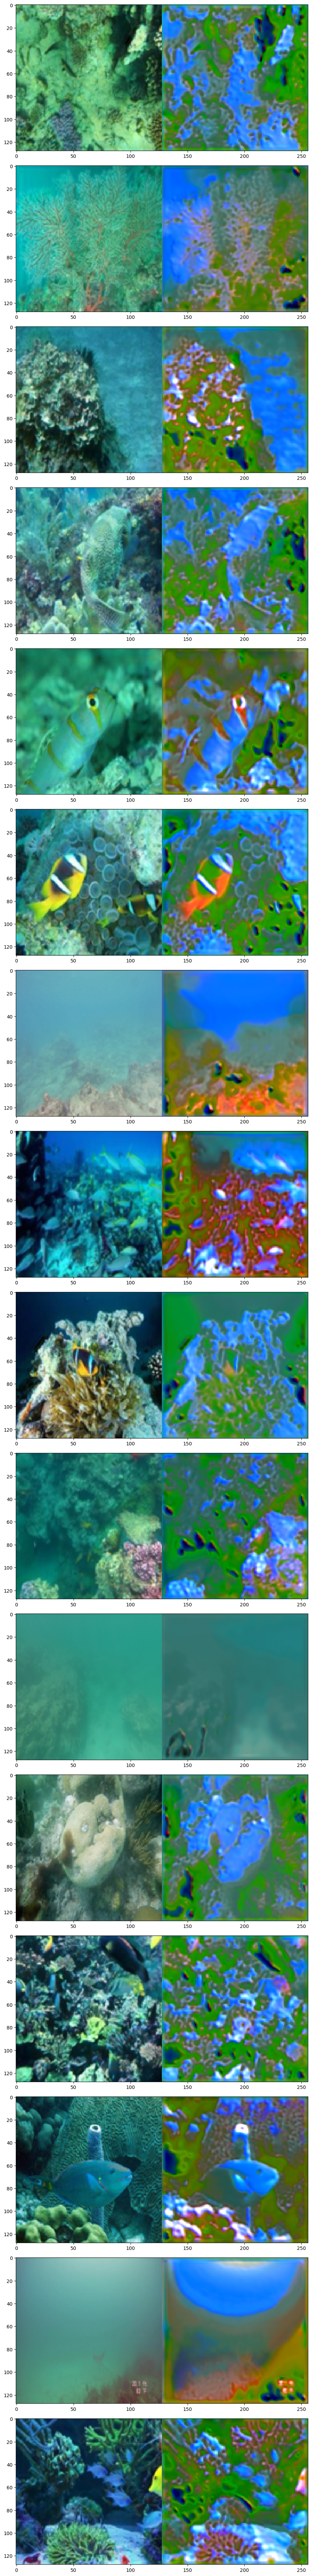

In [ ]:
#testA,testB = tf_data('test')
x_real_A, _ = generate_real(next(trainUnpairedA),n_batch,discriminator_A.output_shape[1])
images_B,_ = generate_fake(x_real_A, generator_A_B,discriminator_A.output_shape[1])
fig,ax = plt.subplots(n_batch,figsize=(75,75))
for index,img in enumerate(zip(x_real_A,images_B)):
    concat_numpy = np.clip(np.hstack((img[0],img[1])),0,1)
    ax[index].imshow(concat_numpy)
fig.tight_layout()